## Missingness Diagnostics & Imputation Planning

This notebook **investigates the patterns and causes of missing data among the variables** that passed the consistency and harmonization checks. Rather than immediately applying statistical imputation, it first examines whether missing values can be logically explained by the relationships between variables.

The analysis follows a two-stage approach: 

**1. Descriptive Diagnostics**

Missingness is explored using descriptive diagnostics to identify which variables and survey months exhibit notable levels of missing data.

**2. Logical and Contextual Assessment**

Logical and contextual relationships between variables are assessed to determine whether missing entries are meaningful, expected, or structurally driven. For example, **missing values in one variable may be reasonable given the recorded value of another variable**, indicating that the absence of data is not random but conditional.

This approach helps distinguish between different types of missingness: **(1) logically implied or structurally valid missing values** and **(2) unexplained missingness that may require statistical treatment**. By prioritizing logical interpretation before imputation, the notebook ensures that **statistical methods are applied only when appropriate and that the original meaning of the survey data is preserved**.

##### Objectives
- Provide a deep understanding of missing data behavior across the survey months.
- Guide informed decisions on whether to apply Deterministic Recoding **(Logic-based)** or Statistical Imputation **(Probability-based)**.
- Preserve the original meaning and intent of the survey design.

This notebook provides an understanding of missing data behavior and guides informed decisions about whether and how imputation should be performed.

---
### Missingness Overview of Consistent Variables

This section provides an overview of data presence across the consistent variables. By loading the **Fraction of Missing Information (FMI)** profile, we can see the total percentage of missing data for each variable throughout the survey months.

It is critical to note that a high missingness percentage (High FMI) does not automatically result in a variable being dropped as this missingness could be structurally driven. For example, variables related to "Hours Worked" will naturally show high missingness among respondents who are *Unemployed* or *Not in the Labor Force*. **Instead of discarding these variables, we perform a logical assessment to determine if these missingness are actually meaningful zeros or structural skips that can be resolved through logic-based recoding.**

FILE LOADED: fmi_profile_consistent.csv
TOTAL CONSISTENT VARIABLES: 20


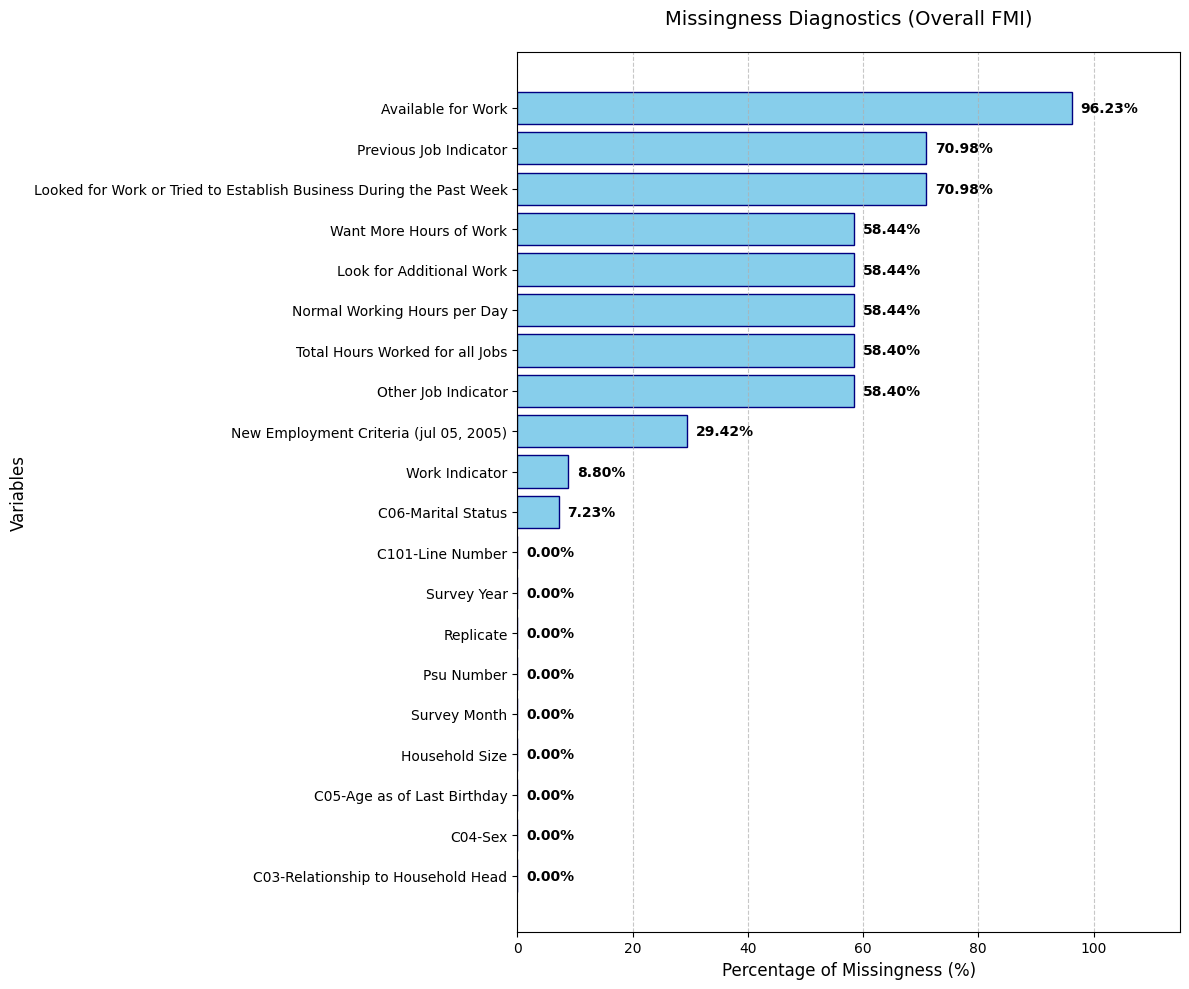

,Variable,ConsistencyTag,TotalMissing,TotalRows,AvgFMI,MonthsObserved,OverallFMI,Flag,Recommendation
0,Available for Work,consistent,5761109,5986548,0.966259,40,0.962342,Critical,Validate/Drop
8,Looked for Work or Tried to Establish Business...,consistent,4249287,5986548,0.721832,40,0.709806,Critical,Validate/Drop
12,Previous Job Indicator,consistent,4249287,5986548,0.721832,40,0.709806,Critical,Validate/Drop
10,Normal Working Hours per Day,consistent,3498660,5986548,0.569600,40,0.584420,Critical,Validate/Drop
18,Want More Hours of Work,consistent,3498660,5986548,0.569600,40,0.584420,Critical,Validate/Drop
7,Look for Additional Work,consistent,3498660,5986548,0.569600,40,0.584420,Critical,Validate/Drop
11,Other Job Indicator,consistent,3496057,5986548,0.569239,40,0.583985,Critical,Validate/Drop
17,Total Hours Worked for all Jobs,consistent,3496057,5986548,0.569239,40,0.583985,Critical,Validate/Drop
9,"New Employment Criteria (jul 05, 2005)",consistent,1761399,5986548,0.291432,40,0.294226,High,Structural Skip - Logical Imputation
19,Work Indicator,consistent,527075,5986548,0.087308,40,0.088043,Moderate,Impute/Keep


In [1]:
import json
from pathlib import Path
import os
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt

# 1. Load config
with open(Path("./data/interim/config.json")) as f:
    cfg = json.load(f)

BASE_PATH = Path(cfg["BASE_PATH"])
MONTH_ORDER = cfg["MONTH_ORDER"]

# --- PATH DEFINITIONS ---
SOURCE_ROOT = BASE_PATH / "FINAL Consistent Surveys"
FMI_ROOT = BASE_PATH / "NEW FMI Reports"
CONSISTENT_FMI_PATH = FMI_ROOT / "fmi_profile_consistent.csv"

# 2. Load the Consistent Variables list and Visualize
try:
    fmi_consistent_df = pd.read_csv(CONSISTENT_FMI_PATH)
    consistent_vars = fmi_consistent_df['Variable'].tolist()
    
    print("="*60)
    print(f"FILE LOADED: {CONSISTENT_FMI_PATH.name}")
    print(f"TOTAL CONSISTENT VARIABLES: {len(consistent_vars)}")
    print("="*60)
    
    # Sort for better visualization (highest missingness at the top)
    plot_df = fmi_consistent_df.sort_values(by='OverallFMI', ascending=True)
    
    # --- VISUALIZATION: MISSINGNESS PERCENTAGE ---
    # Increased height (12) to prevent vertical overlapping of variable names
    plt.figure(figsize=(12, 10)) 
    
    # Create horizontal bar chart
    # Multiply FMI by 100 to show as a percentage
    missing_pct = plot_df['OverallFMI'] * 100
    bars = plt.barh(plot_df['Variable'], missing_pct, color='skyblue', edgecolor='navy')
    
    # Formatting
    plt.xlabel('Percentage of Missingness (%)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.title('Missingness Diagnostics (Overall FMI)', fontsize=14, pad=20)
    
    # --- ADJUSTMENT: Padding for labels ---
    # We set the limit to 115% to ensure the text labels on the right don't clip
    max_val = missing_pct.max()
    plt.xlim(0, max_val + 15 if max_val < 85 else 115) 
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add percentage labels on the bars for clarity
    for bar in bars:
        width = bar.get_width()
        # Add a small offset so text doesn't touch the bar
        plt.text(width + 1.5, bar.get_y() + bar.get_height()/2, 
                 f'{width:.2f}%', va='center', fontsize=10, fontweight='bold')

    # tight_layout(rect=...) can help if you still see clipping on the edges
    plt.tight_layout() 
    plt.show()

    # Preview the Macro-Summary table
    display(fmi_consistent_df.sort_values(by='OverallFMI', ascending=False))
    
except Exception as e:
    print(f"[ERROR] Could not load consistent variable list or generate plot: {e}")

#### Categorical Value Reference Dictionary

This section generates a reference dictionary of unique category values for each categorical variable included in the consistent variable set. Numeric and temporal variables are excluded to focus only on variables with meaningful labels.

For each categorical variable, the notebook extracts and consolidates unique response categories across survey years. The resulting dictionary is used as a guide for logical missingness assessment, helping interpret whether missing values are reasonable given the structure and meaning of each variable.

In [2]:
import pandas as pd
from pathlib import Path

# --- GLOBAL CONSTANTS ---
# Adding the missing definition to handle various "empty" string representations
TEXT_MISSING = ["", " ", "nan", "NaN", "n/a", "N/A", "none", "None", ".", ".."]

# --- CONFIGURATION FROM USER ---
TEMPORAL_VARS = ["Survey Month", "Survey Year"]
NUMERIC_ACTUAL_VARS = [
    "C101-Line Number", "Normal Working Hours per Day", "Psu Number", 
    "Replicate", "C05-Age as of Last Birthday", 
    "Household Size", "Total Hours Worked for all Jobs"
]

# Combined skip list
SKIP_METADATA = set(TEMPORAL_VARS + NUMERIC_ACTUAL_VARS)

def run_metadata_audit_v2(base_path, vars_list):
    metadata_map = {}
    year_folders = sorted([d for d in base_path.iterdir() if d.is_dir()])

    print(" AUDITING CATEGORICAL METADATA (Skipping Numeric/Temporal)...")
    
    for year_folder in year_folders:
        try:
            # Check one file per year to capture potential code changes
            sample_file = next(year_folder.glob("*.csv"))
            
            # Determine available columns to avoid loading errors
            available = pd.read_csv(sample_file, nrows=0).columns.tolist()
            target_cols = [v for v in vars_list if v in available and v not in SKIP_METADATA]
            
            if not target_cols:
                continue

            df = pd.read_csv(sample_file, usecols=target_cols, dtype=str)
            
            for col in df.columns:
                # Extract unique values, drop actual NaNs, and strip whitespace
                raw_unique = df[col].dropna().unique()
                # Use the global TEXT_MISSING list to filter out placeholder strings
                clean_unique = [v.strip() for v in raw_unique if v.strip() not in TEXT_MISSING]
                
                if col not in metadata_map:
                    metadata_map[col] = set()
                metadata_map[col].update(clean_unique)
        
        except (StopIteration, Exception) as e:
            print(f"   Skipping {year_folder.name}: {e}")
            continue

    # --- FORMATTED OUTPUT ---
    print("\n" + "="*95)
    print(f"{'CATEGORICAL VARIABLE':<40} | {'UNIQUE CODES'}")
    print("="*95)
    
    for var, values in sorted(metadata_map.items()):
        # Sorting logic: Numbers first (as strings), then alphabetic
        sorted_vals = sorted(list(values), key=lambda x: (x.isdigit(), x))
        print(f"{var:<40} | {', '.join(sorted_vals)}")

    return metadata_map

# Execute
categorical_metadata = run_metadata_audit_v2(SOURCE_ROOT, consistent_vars)

 AUDITING CATEGORICAL METADATA (Skipping Numeric/Temporal)...

CATEGORICAL VARIABLE                     | UNIQUE CODES
Available for Work                       | no, yes
C03-Relationship to Household Head       | boarder, child, domestic helper, grandchild, head, in-law relative, non-relative, other relative, parent, sibling, spouse
C04-Sex                                  | female, male
C06-Marital Status                       | annulled, divorced/separated, married or common-law/live-in, single, unknown, widowed
Look for Additional Work                 | no, yes
Looked for Work or Tried to Establish Business During the Past Week | no, yes
New Employment Criteria (jul 05, 2005)   | employed, not in the labor force, unemployed
Other Job Indicator                      | no, yes
Previous Job Indicator                   | no, yes
Want More Hours of Work                  | no, yes
Work Indicator                           | no, yes


### Logic-Based Missingness Assessment Using Employment Status as a Reference Variable

This section applies a logic-driven approach to missingness diagnostics by using the variable **New Employment Criteria (Jul 05, 2005)** as a reference variable. Instead of immediately relying on statistical imputation, the analysis first examines *whether missing values in work-related variables are logically consistent with an individual’s employment status*.

The variable has three employment categories: **employed**, **unemployed**, and **not in the labor force**. For each category, the notebook evaluates the presence and absence of data in key work-related variables, including numeric indicators (e.g., Normal Working Hours per Day) and categorical indicators (e.g., Work Indicator).

By determining the proportion of missing and non-missing values within each employment group, the analysis identifies whether missingness reflects expected real-world conditions. *For example, missing working hours among individuals classified as “not in the labor force” may represent a structurally valid absence of data rather than a data quality issue.*

This approach is important as it distinguishes **meaningful structural missingness** from **problematic data missingness**. It ensures that subsequent imputation decisions are guided not only by statistical patterns but also by the logical relationships between variables, leading to more valid and interpretable results in later analysis.

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

# Constants 
FINAL_SOURCE = BASE_PATH / "FINAL Consistent Surveys"
TEXT_MISSING = ["", " ", "nan", "NaN", "n/a", "N/A", "none", "None", ".", ".."]

def audit_by_specific_category(year, month):
    year_dir = FINAL_SOURCE / year
    try:
        file_path = next(year_dir.glob(f"{month}*.csv"))
    except StopIteration:
        print(f" File not found for {month} {year}")
        return

    ROOT_VAR = "New Employment Criteria (jul 05, 2005)"
    
    WORK_NUMERIC = ["Normal Working Hours per Day", "Total Hours Worked for all Jobs"]
    WORK_CATEGORICAL = [
        "Work Indicator",
        "Available for Work",
        "Looked for Work or Tried to Establish Business During the Past Week",
        "Previous Job Indicator",
        "Want More Hours of Work", 
        "Look for Additional Work", 
        "Other Job Indicator"
    ]
    
    df = pd.read_csv(file_path, usecols=[ROOT_VAR] + WORK_NUMERIC + WORK_CATEGORICAL, dtype=str)

    # Now including 'employed' alongside 'unemployed' and 'not in the labor force'
    categories = ['employed', 'unemployed', 'not in the labor force']
    
    for cat in categories:
        sub_df = df[df[ROOT_VAR].str.strip().str.lower() == cat].copy()
        
        if sub_df.empty:
            print(f"\n No records found for category: {cat}")
            continue

        # --- PART 1: NUMERIC ---
        num_rows = []
        for var in WORK_NUMERIC:
            is_missing = sub_df[var].isna() | sub_df[var].str.strip().isin(TEXT_MISSING)
            status = np.where(is_missing, " MISSING", " DATA PRESENT")
            counts = pd.Series(status).value_counts(normalize=True) * 100
            counts_dict = {k: v for k, v in counts.to_dict().items()}
            for key in [" MISSING", " DATA PRESENT"]:
                if key not in counts_dict: counts_dict[key] = 0.0
            counts_dict['Variable'] = var
            num_rows.append(counts_dict)
        num_report = pd.DataFrame(num_rows).set_index('Variable')

        # --- PART 2: CATEGORICAL ---
        cat_rows = []
        for var in WORK_CATEGORICAL:
            is_missing = sub_df[var].isna() | sub_df[var].str.strip().isin(TEXT_MISSING)
            status = sub_df[var].str.strip().str.lower()
            status = np.where(is_missing, " missing", status)
            counts = pd.Series(status).value_counts(normalize=True) * 100
            counts_dict = {k: v for k, v in counts.to_dict().items()}
            for key in ["yes", "no", " missing"]:
                if key not in counts_dict: counts_dict[key] = 0.0
            counts_dict['Variable'] = var
            cat_rows.append(counts_dict)
        cat_report = pd.DataFrame(cat_rows).set_index('Variable')

        # --- DISPLAY ---
        print(f"\n" + "="*80)
        print(f" CATEGORY AUDIT: {cat.upper()}")
        print(f"Source: {month} {year} | Total People: {len(sub_df)}")
        print("="*80)
        
        print(f"\n[Numeric Presence - {cat.capitalize()}]")
        display(num_report[[" DATA PRESENT", " MISSING"]].round(2).astype(str) + '%')

        print(f"\n[Categorical Responses - {cat.capitalize()}]")
        display(cat_report[["yes", "no", " missing"]].round(2).astype(str) + '%')

# Execute
audit_by_specific_category("2018", "January")


 CATEGORY AUDIT: EMPLOYED
Source: January 2018 | Total People: 70812

[Numeric Presence - Employed]


,DATA PRESENT,MISSING
Variable,,
Normal Working Hours per Day,100.0%,0.0%
Total Hours Worked for all Jobs,100.0%,0.0%



[Categorical Responses - Employed]


,yes,no,missing
Variable,,,
Work Indicator,99.02%,0.98%,0.0%
Available for Work,0.0%,0.0%,100.0%
Looked for Work or Tried to Establish Business During the Past Week,0.0%,0.0%,100.0%
Previous Job Indicator,0.0%,0.0%,100.0%
Want More Hours of Work,18.26%,81.74%,0.0%
Look for Additional Work,10.26%,89.74%,0.0%
Other Job Indicator,8.11%,91.89%,0.0%



 CATEGORY AUDIT: UNEMPLOYED
Source: January 2018 | Total People: 3625

[Numeric Presence - Unemployed]


,DATA PRESENT,MISSING
Variable,,
Normal Working Hours per Day,0.0%,100.0%
Total Hours Worked for all Jobs,0.0%,100.0%



[Categorical Responses - Unemployed]


,yes,no,missing
Variable,,,
Work Indicator,0.0%,100.0%,0.0%
Available for Work,100.0%,0.0%,0.0%
Looked for Work or Tried to Establish Business During the Past Week,43.92%,56.08%,0.0%
Previous Job Indicator,81.49%,18.51%,0.0%
Want More Hours of Work,0.0%,0.0%,100.0%
Look for Additional Work,0.0%,0.0%,100.0%
Other Job Indicator,0.0%,0.0%,100.0%



 CATEGORY AUDIT: NOT IN THE LABOR FORCE
Source: January 2018 | Total People: 45877

[Numeric Presence - Not in the labor force]


,DATA PRESENT,MISSING
Variable,,
Normal Working Hours per Day,0.0%,100.0%
Total Hours Worked for all Jobs,0.0%,100.0%



[Categorical Responses - Not in the labor force]


,yes,no,missing
Variable,,,
Work Indicator,0.0%,100.0%,0.0%
Available for Work,0.0%,4.77%,95.23%
Looked for Work or Tried to Establish Business During the Past Week,0.26%,99.74%,0.0%
Previous Job Indicator,55.12%,44.88%,0.0%
Want More Hours of Work,0.0%,0.0%,100.0%
Look for Additional Work,0.0%,0.0%,100.0%
Other Job Indicator,0.0%,0.0%,100.0%


#### Interpretation of Logic-Based Missingness Patterns (January 2018 sample)

The results show that missingness in work-related variables is largely structurally logical and aligned with employment status rather than random data loss.

- **Employed respondents**

For employed individuals, working-hours variables(`Normal Working Hours per Day` and `Total Hours Worked for all Jobs`) are fully observed, which is expected since employed respondents actively participate in work. Job search and availability variables (`Available for Work`, `Looked for Work or Tried to Establish Business During the Past Week`, and `Previous Job Indicator`) are entirely missing. This suggests that these questions may not applicable to employed respondents and are likely skipped by the survey design. For categorical work indicators, `Work Indicator` shows a dominance of “yes” (99.02%) and a very small proportion of “no” (0.98%). This distribution reinforces the internal consistency of the data that respondents classified as employed are almost universally identified as working, with only minimal deviations that may reflect reporting errors, transitional employment states, or classification noise. Variables related to additional work (`Want More Hours of Work`, `Look for Additional Work`, and `Other Job Indicator`) are fully observed. Their presence indicates that, within the employed group, the survey actively captures variations in work intensity and job multiplicity, rather than omitting these dimensions.

- **Unemployed respondents**

For unemployed individuals, working-hours variables (`Normal Working Hours per Day` and `Total Hours Worked for all Jobs`) are completely missing, which is logically consistent because unemployed respondents do not have active working hours. The `Work Indicator` variable shows **100% “no”**, which is conceptually coherent with unemployment status and confirms the structural alignment between employment classification and work activity indicators. Job search-related variables reveal meaningful behavioral patterns rather than random responses. `Available for Work` is **100% “yes”** indicating that unemployed individuals are consistently classified as available for employment. Meanwhile, `Looked for Work or Tried to Establish Business During the Past Week` shows a split distribution (43.92% yes, 56.08% no), suggesting variety in job-search activity within the unemployed population. This implies that not all unemployed individuals are actively seeking work at the same time. Similarly, `Previous Job Indicator` shows a high proportion of “yes” (81.49%) and a smaller proportion of “no” (18.51%), indicating that most unemployed respondents previously held a job, while a minority may be first-time job seekers or individuals with no prior employment history. In contrast, variables related to additional work (`Want More Hours of Work`, `Look for Additional Work`, and `Other Job Indicator`) are entirely missing, reinforcing the idea that these questions are not applicable to unemployed respondents.

- **Not in the Labor Force respondents**

For individuals not in the labor force, working-hours variables (`Normal Working Hours per Day` and `Total Hours Worked for all Jobs`) are fully missing, which is expected because these respondents are not engaged in employment. The `Work Indicator` variable shows **100% “no”** confirming that individuals outside the labor force are consistently classified as not working. Job search-related variables exhibit very low levels of active labor-market engagement. `Looked for Work or Tried to Establish Business During the Past Week` is almost entirely “no” (99.74%), with only a small “yes” proportion (0.26%), indicating that job-search activity is rare in this group. This aligns with the conceptual definition of being outside the labor force. The `Previous Job Indicator` shows a more balanced distribution (55.12% yes, 44.88% no), suggesting that a substantial portion of individuals outside the labor force previously held jobs, while others may never have been employed. This highlights the variety of this group, which may include retirees, students, homemakers, or discouraged workers. For `Available for Work`, the high missingness rate (95.23%) and small proportion of “no” responses (4.77%) suggest that this question may not applied to individuals outside the labor force, further supporting the presence of survey skip patterns rather than data quality issues. Variables related to additional work (`Want More Hours of Work`, `Look for Additional Work`, and `Other Job Indicator`) are entirely missing, showing their irrelevance for this group.

**Overall implication:**
These patterns indicate that missingness in work-related variables is predominantly structural and **conditional on employment status, rather than data quality issues**. Therefore, imputing these variables without considering employment status would risk introducing unrealistic values and distorting the meaning of the data.

---
### Longitudinal Consistency of Employment-Related Variables

This section evaluates whether **the patterns of data presence and categorical responses remain consistent across all survey months**. Instead of analyzing a single period, it aggregates results across the entire timeline to determine whether missingness and response distributions are stable, structural, and systematic.

The goal is to verify that observed missingness is not random or month-specific, but rather follows consistent survey logic. By summarizing all months in one report, this step strengthens the validity of subsequent decisions on imputation, exclusion, and interpretation of variables.

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path

# Constants 
FINAL_SOURCE = BASE_PATH / "FINAL Consistent Surveys"
TEXT_MISSING = ["", " ", "nan", "NaN", "n/a", "N/A", "none", "None", ".", ".."]

def run_master_stability_check():
    ROOT_VAR = "New Employment Criteria (jul 05, 2005)"
    
    WORK_NUMERIC = ["Normal Working Hours per Day", "Total Hours Worked for all Jobs"]
    WORK_CATEGORICAL = [
        "Work Indicator",
        "Available for Work",
        "Looked for Work or Tried to Establish Business During the Past Week",
        "Previous Job Indicator",
        "Want More Hours of Work", 
        "Look for Additional Work", 
        "Other Job Indicator"
    ]
    ALL_VARS = WORK_NUMERIC + WORK_CATEGORICAL
    categories = ['employed', 'unemployed', 'not in the labor force']
    
    # Store results for every month
    audit_log = {cat: {var: [] for var in ALL_VARS} for cat in categories}
    
    # --- ADDITION: Track global distribution ---
    category_distribution_history = []
    
    total_months = 0
    csv_files = sorted(list(FINAL_SOURCE.rglob("*.csv")))
    
    print(f" Auditing {len(csv_files)} months for data stability and distribution...")

    for file_path in csv_files:
        total_months += 1
        year = file_path.parent.name
        month = file_path.stem.split('_')[0].capitalize()
        period = f"{month} {year}"
        
        df = pd.read_csv(file_path, usecols=[ROOT_VAR] + ALL_VARS, dtype=str)

        # --- ADDITION: Calculate distribution for THIS month ---
        raw_status = df[ROOT_VAR].str.strip().str.lower()
        # Define missing as anything in TEXT_MISSING or actual NaN
        is_root_missing = raw_status.isna() | raw_status.isin(TEXT_MISSING)
        
        status_counts = raw_status.value_counts(dropna=False).to_dict()
        total_rows = len(df)
        
        # Aggregate counts for the summary
        dist_entry = {cat: status_counts.get(cat, 0) for cat in categories}
        dist_entry['missing'] = is_root_missing.sum()
        dist_entry['total'] = total_rows
        category_distribution_history.append(dist_entry)

        for cat in categories:
            sub_df = df[raw_status == cat].copy()
            if sub_df.empty: continue

            for var in ALL_VARS:
                val_clean = sub_df[var].str.strip().str.lower()
                is_missing = val_clean.isna() | val_clean.isin(TEXT_MISSING)
                
                present_pct = (1 - is_missing.mean()) * 100
                
                if present_pct > 0:
                    entry = {
                        "period": period, 
                        "present_pct": round(present_pct, 2),
                        "missing_pct": round(100 - present_pct, 2)
                    }
                    
                    if var in WORK_CATEGORICAL:
                        present_data = val_clean[~is_missing]
                        unique_ans = set(present_data.unique())
                        if unique_ans == {'no'}:
                            entry['dist'] = "only 'no'"
                        elif unique_ans == {'yes'}:
                            entry['dist'] = "only 'yes'"
                        else:
                            entry['dist'] = "distributed between yes/no"
                    
                    audit_log[cat][var].append(entry)

    # --- NEW: MACRO DISTRIBUTION REPORT ---
    print("\n" + "="*85)
    print(f" OVERALL LABOR FORCE DISTRIBUTION (Across {total_months} months)")
    print("="*85)
    
    total_samples = sum(d['total'] for d in category_distribution_history)
    for cat in categories + ['missing']:
        cat_total = sum(d[cat] for d in category_distribution_history)
        avg_pct = (cat_total / total_samples) * 100
        label = cat.upper() if cat != 'missing' else "MISSING DATA"
        print(f" {label:<35} : {avg_pct:>6.2f}%")

    # --- EXISTING REPORT GENERATION ---
    for cat in categories:
        print(f"\n" + "="*85)
        print(f"  LONGITUDINAL REPORT: {cat.upper()}")
        print(f" Total Period: {total_months} Survey Months")
        print("="*85)

        for section_name, var_list in [("Numeric", WORK_NUMERIC), ("Categorical", WORK_CATEGORICAL)]:
            print(f"\n[{section_name} Presence - {cat.capitalize()}]")
            
            for var in var_list:
                leaks = audit_log[cat][var]
                
                if not leaks:
                    print(f"   {var}: 100% missing in all {total_months} survey months.")
                
                elif len(leaks) == total_months:
                    all_full = all(l['present_pct'] == 100.0 for l in leaks)
                    if all_full:
                        dist_msg = f" (Responses: {leaks[0]['dist']})" if var in WORK_CATEGORICAL else ""
                        print(f"   {var}: 0% missing in all {total_months} months{dist_msg}.")
                    else:
                        avg_p = sum(l['present_pct'] for l in leaks) / total_months
                        unique_dists = set([l.get('dist', 'N/A') for l in leaks])
                        dist_msg = f" (Responses: {', '.join(unique_dists)})" if var in WORK_CATEGORICAL else ""
                        print(f"   {var}: Data present in all {total_months} months, but averages {round(avg_p, 2)}% presence{dist_msg}.")

                else:
                    print(f"   {var}: Variable is mostly missing, but data was found in {len(leaks)}/{total_months} months.")
                    for l in leaks:
                        dist_msg = f" | Responses: {l['dist']}" if 'dist' in l else ""
                        print(f"    -> {l['period']}: {l['present_pct']}% present{dist_msg}")

# Run
run_master_stability_check()

 Auditing 40 months for data stability and distribution...

 OVERALL LABOR FORCE DISTRIBUTION (Across 40 months)
 EMPLOYED                            :  41.56%
 UNEMPLOYED                          :   2.02%
 NOT IN THE LABOR FORCE              :  27.00%
 MISSING DATA                        :  29.42%

  LONGITUDINAL REPORT: EMPLOYED
 Total Period: 40 Survey Months

[Numeric Presence - Employed]
   Normal Working Hours per Day: 0% missing in all 40 months.
   Total Hours Worked for all Jobs: 0% missing in all 40 months.

[Categorical Presence - Employed]
   Work Indicator: 0% missing in all 40 months (Responses: distributed between yes/no).
   Available for Work: 100% missing in all 40 survey months.
   Looked for Work or Tried to Establish Business During the Past Week: 100% missing in all 40 survey months.
   Previous Job Indicator: 100% missing in all 40 survey months.
   Want More Hours of Work: 0% missing in all 40 months (Responses: distributed between yes/no).
   Look for Addition

#### Interpretation:

Across 40 survey months, **the results show a highly stable and logically consistent pattern of data presence and responses by employment status**. 

- For **employed** respondents, numeric work variables (normal working hours and total hours worked) are always fully observed, while job-search-related variables (available for work, looked for work, and previous job indicator) are consistently missing, indicating that these questions may not be structurally not applicable to employed individuals. At the same time, work-related indicators (work indicator, desire for more hours, additional work, and other job indicator) are always present with responses distributed between “yes” and “no,” reflecting meaningful variation rather than data gaps. 

- For **unemployed** and **not in the labor force** respondents, the previous job indicator is consistently observed across all months, while variables related to additional work are always missing, suggesting that they are systematically excluded for this group. 

The stability of both missingness and response distributions across time confirms that **the observed missing data are structural and conditional on employment status**, not random inconsistencies, reinforcing the validity of using employment criteria as a logical basis for interpreting missingness patterns.

---
### Logic-Based Recoding Strategy for Structurally Missing Work Variables

Based on the longitudinal missingness analysis, certain work-related variables are consistently 100% missing for respondents classified as **Unemployed** and **Not in the Labor Force** under the *New Employment Criteria (Jul 05, 2005)* in all survey months. This pattern is stable across all survey months, indicating that the missing values are structural.

For these groups, the following recoding strategy will be applied:

- **Numeric variables**
  - Normal Working Hours per Day → recoded to `0`
  - Total Hours Worked for All Jobs → recoded to `0`

  **Justification:** A person without a job cannot logically accumulate working hours.

- **Categorical variables (yes/no)**
  - Other Job Indicator → recoded to `no`
  - Want More Hours of Work → recoded to `no`
  - Look for Additional Work → recoded to `no`

  **Justification:** These questions are only relevant to those who currently have at least one job.

This approach does not rely on statistical imputation but on logical consistency with employment status. **Since unemployed and work-inactive individuals do not engage in work activities, assigning zero working hours and “no” responses preserves the semantic meaning of the variables and prevents unrealistic imputed values.**

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- CONFIGURATION ---
# We use the SOURCE_ROOT defined in your previous blocks
# TARGET_DIR: Where the "Logic-Corrected" files will be saved
TARGET_ROOT = BASE_PATH / "CLEANED Logic-Corrected Surveys"
TARGET_ROOT.mkdir(parents=True, exist_ok=True)

TEXT_MISSING = ["", " ", "nan", "NaN", "n/a", "N/A", "none", "None", ".", ".."]

# Variables to be recoded for Unemployed and NILF
DETERMINISTIC_MAP = {
    "Numeric": {
        "Normal Working Hours per Day": "0",
        "Total Hours Worked for all Jobs": "0"
    },
    "Categorical": {
        "Other Job Indicator": "no",
        "Want More Hours of Work": "no",
        "Look for Additional Work": "no"
    }
}

def apply_deterministic_imputation():
    ROOT_VAR = "New Employment Criteria (jul 05, 2005)"
    csv_files = sorted(list(SOURCE_ROOT.rglob("*.csv")))
    
    print(f" Processing {len(csv_files)} months for Deterministic Imputation...")

    for file_path in csv_files:
        # 1. Load Data
        df = pd.read_csv(file_path, dtype=str)
        
        # 2. Identify Target Rows (Non-Workers)
        # We strip and lowercase to ensure the match is robust
        is_non_worker = df[ROOT_VAR].str.strip().str.lower().isin(['unemployed', 'not in the labor force'])
        
        # 3. Apply Numeric Logic (Set to "0")
        for var, replacement in DETERMINISTIC_MAP["Numeric"].items():
            if var in df.columns:
                # Only replace if the row is a non-worker AND the value is currently missing
                is_missing = df[var].isna() | df[var].str.strip().isin(TEXT_MISSING)
                df.loc[is_non_worker & is_missing, var] = replacement

        # 4. Apply Categorical Logic (Set to "no")
        for var, replacement in DETERMINISTIC_MAP["Categorical"].items():
            if var in df.columns:
                is_missing = df[var].isna() | df[var].str.strip().isin(TEXT_MISSING)
                df.loc[is_non_worker & is_missing, var] = replacement

        # 5. Save the logic-corrected file
        # Maintain the same folder structure (Year/Month_Year.csv)
        relative_path = file_path.relative_to(SOURCE_ROOT)
        save_path = TARGET_ROOT / relative_path
        save_path.parent.mkdir(parents=True, exist_ok=True)
        
        df.to_csv(save_path, index=False)
        print(f"   Saved: {relative_path}")

    print("\n" + "="*60)
    print("DONE: Logical Nulls have been resolved for Unemployed/Not in the Labor Force.")
    print(f"Cleaned files are located in: {TARGET_ROOT}")
    print("="*60)

# Run the process
apply_deterministic_imputation()

 Processing 40 months for Deterministic Imputation...
   Saved: 2018\APRIL_2018.CSV
   Saved: 2018\JANUARY_2018.CSV
   Saved: 2018\JULY_2018.CSV
   Saved: 2018\OCTOBER_2018.CSV
   Saved: 2019\APRIL_2019.CSV
   Saved: 2019\JANUARY_2019.CSV
   Saved: 2019\JULY_2019.CSV
   Saved: 2019\OCTOBER_2019.CSV
   Saved: 2022\APRIL_2022.csv
   Saved: 2022\AUGUST_2022.CSV
   Saved: 2022\DECEMBER_2022.CSV
   Saved: 2022\FEBRUARY_2022.csv
   Saved: 2022\JANUARY_2022.csv
   Saved: 2022\JULY_2022.CSV
   Saved: 2022\JUNE_2022.csv
   Saved: 2022\MARCH_2022.csv
   Saved: 2022\MAY_2022.csv
   Saved: 2022\NOVEMBER_2022.CSV
   Saved: 2022\OCTOBER_2022.CSV
   Saved: 2022\SEPTEMBER_2022.CSV
   Saved: 2023\APRIL_2023.CSV
   Saved: 2023\AUGUST_2023.CSV
   Saved: 2023\DECEMBER_2023.CSV
   Saved: 2023\FEBRUARY_2023.CSV
   Saved: 2023\JANUARY_2023.CSV
   Saved: 2023\JULY_2023.CSV
   Saved: 2023\JUNE_2023.CSV
   Saved: 2023\MARCH_2023.CSV
   Saved: 2023\MAY_2023.CSV
   Saved: 2023\NOVEMBER_2023.CSV
   Saved: 2023\OCT

In [8]:
def run_imputation_validation():
    ROOT_VAR = "New Employment Criteria (jul 05, 2005)"
    # Combined list of variables to check
    TARGET_VARS = list(DETERMINISTIC_MAP["Numeric"].keys()) + list(DETERMINISTIC_MAP["Categorical"].keys())
    
    corrected_files = sorted(list(TARGET_ROOT.rglob("*.csv")))
    
    print("\n" + "="*105)
    print("           VALIDATION REPORT: DETERMINISTIC IMPUTATION & VALUE DISTRIBUTION (NON-WORKERS)           ")
    print("="*105)
    print(f" Checking {len(corrected_files)} months in: {TARGET_ROOT.name}")
    
    # Store counts and unique values found across all files
    overall_stats = {var: {"missing_count": 0, "total_rows": 0, "found_values": set()} for var in TARGET_VARS}

    for file_path in corrected_files:
        df = pd.read_csv(file_path, usecols=[ROOT_VAR] + TARGET_VARS, dtype=str)
        
        # Filter for Non-Workers
        is_non_worker = df[ROOT_VAR].str.strip().str.lower().isin(['unemployed', 'not in the labor force'])
        sub_df = df[is_non_worker]
        
        if sub_df.empty:
            continue

        for var in TARGET_VARS:
            val_series = sub_df[var].str.strip().str.lower()
            is_missing = val_series.isna() | val_series.isin(TEXT_MISSING)
            
            overall_stats[var]["missing_count"] += is_missing.sum()
            overall_stats[var]["total_rows"] += len(sub_df)
            
            # Capture non-null values to verify they are '0' or 'no'
            unique_vals = val_series.dropna().unique()
            overall_stats[var]["found_values"].update(unique_vals)

    # --- Print Detailed Table ---
    header = f"{'VARIABLE':<40} | {'MISSING':<15} | {'DISTRIBUTION (Unique Values Found)':<35}"
    print(f"\n{header}")
    print("-" * 105)
    
    all_clean = True
    for var in TARGET_VARS:
        stats = overall_stats[var]
        missing = stats["missing_count"]
        total = stats["total_rows"]
        # Convert set to sorted list for clean printing
        vals_found = sorted(list(stats["found_values"]))
        
        # Determine status
        if missing > 0:
            status_text = "[REMAINING]"
            all_clean = False
        else:
            status_text = "[FIXED]"
            
        missing_label = f"{missing:,} {status_text}"
        dist_label = f"{', '.join(vals_found)}" if vals_found else "EMPTY"
        
        print(f"{var:<40} | {missing_label:<15} | {dist_label:<35}")

    print("\n" + "="*105)
    if all_clean:
        print(" SUCCESS: All targets for Unemployed/Not in the Labor Force rows are now recoded.")
        print(" VERIFICATION: Distribution column confirms Numeric = ['0'] and Categorical = ['no'].")
    else:
        print(" ALERT: Some target rows are still missing data. Verify logic or variable names.")
    print("="*105)

# Run the validation
run_imputation_validation()


           VALIDATION REPORT: DETERMINISTIC IMPUTATION & VALUE DISTRIBUTION (NON-WORKERS)           
 Checking 40 months in: CLEANED Logic-Corrected Surveys

VARIABLE                                 | MISSING         | DISTRIBUTION (Unique Values Found) 
---------------------------------------------------------------------------------------------------------
Normal Working Hours per Day             | 0 [FIXED]       | 0                                  
Total Hours Worked for all Jobs          | 0 [FIXED]       | 0                                  
Other Job Indicator                      | 0 [FIXED]       | no                                 
Want More Hours of Work                  | 0 [FIXED]       | no                                 
Look for Additional Work                 | 0 [FIXED]       | no                                 

 SUCCESS: All targets for Unemployed/Not in the Labor Force rows are now recoded.
 VERIFICATION: Distribution column confirms Numeric = ['0'] and Catego

# Diagnostic: Identifying Structural Gaps in Demographics

Before applying any logic-based imputation, we first isolate the missing values in `C101-Line Number` and `C06-Marital Status` to confirm they are structural errors rather than random data loss.

**1. Line Number Gaps (The Sandwich Check)**
We inspect the rows immediately **above and below** the missing Line Numbers. By looking at the neighbors, we can infer the missing value. For example, if the row above is `1` and the row below is `3`, the missing value is likely `2`.

**2. Missing Marital Status in Infants**
We filter for records where Marital Status is missing but the Age is less than 5. If these exist, it confirms that the field was likely skipped because the question is inapplicable to toddlers.

## Diagnostic (The Sandwich Check) for C101-Line Number

In [28]:
import pandas as pd
from pathlib import Path
import json

# Load Config
with open(Path("./data/interim/config.json")) as f:
    config = json.load(f)

BASE_PATH = Path(config["BASE_PATH"])
SOURCE_DIR = BASE_PATH / "FINAL Consistent Surveys"

print(f"DIAGNOSTIC REPORT: STRUCTURAL ANOMALIES\n")

files = sorted(list(SOURCE_DIR.rglob("*.csv")))

for file_path in files:
    try:
        df = pd.read_csv(file_path, low_memory=False)
        
        # --- CHECK 1: LINE NUMBERS (SANDWICH VIEW) ---
        if "C101-Line Number" in df.columns:
            # Find missing rows
            missing_line = df["C101-Line Number"].astype(str).str.strip().replace({'nan': None, 'None': None}).isna()
            missing_indexes = df[missing_line].index.tolist()
            
            if missing_indexes:
                print(f"{file_path.name} | Found {len(missing_indexes)} missing Line Numbers")
                cols = ["C101-Line Number", "C03-Relationship to Household Head", "C05-Age as of Last Birthday"]
                
                for idx in missing_indexes:
                    # Show the "Sandwich" (Up, Target, Down)
                    start = max(0, idx - 1)
                    end = min(len(df), idx + 2)
                    sandwich = df.iloc[start:end][cols].copy()
                    
                    print(f"\n--- Neighbors for Row {idx} ---")
                    print(sandwich.to_string())
                print("="*60)

        # --- CHECK 2: INFANT MARITAL STATUS ---
        if "C06-Marital Status" in df.columns and "C05-Age as of Last Birthday" in df.columns:
            df["C05-Age as of Last Birthday"] = pd.to_numeric(df["C05-Age as of Last Birthday"], errors='coerce')
            missing_status = df["C06-Marital Status"].astype(str).str.strip().replace({'nan': None, 'None': None}).isna()
            
            infant_missing = (df["C05-Age as of Last Birthday"] < 5) & (missing_status)
            count = infant_missing.sum()
            
            if count > 0:
                 print(f"{file_path.name} | Found {count} Infants (Age < 5) with Missing Marital Status")

    except Exception as e:
        print(f"Error reading {file_path.name}: {e}")

DIAGNOSTIC REPORT: STRUCTURAL ANOMALIES

APRIL_2018.CSV | Found 15724 Infants (Age < 5) with Missing Marital Status
JANUARY_2018.CSV | Found 12645 Infants (Age < 5) with Missing Marital Status
JULY_2018.CSV | Found 16372 Infants (Age < 5) with Missing Marital Status
OCTOBER_2018.CSV | Found 15448 Infants (Age < 5) with Missing Marital Status
APRIL_2019.CSV | Found 14434 Infants (Age < 5) with Missing Marital Status
JANUARY_2019.CSV | Found 15758 Infants (Age < 5) with Missing Marital Status
JULY_2019.CSV | Found 14509 Infants (Age < 5) with Missing Marital Status
OCTOBER_2019.CSV | Found 14450 Infants (Age < 5) with Missing Marital Status
APRIL_2022.csv | Found 2 missing Line Numbers

--- Neighbors for Row 110427 ---
        C101-Line Number C03-Relationship to Household Head  C05-Age as of Last Birthday
110426               3.0                              child                           17
110427               NaN                               head                           70
110428

# Logic-Based Imputation

The diagnostics above confirm that these missing values are recoverable using a "Sandwich Logic" approach.

**1. Sequential Logic for Line Numbers**
We determine the correct Line Number by looking at the neighbors (Up and Down) and cross-referencing it with the **Relationship** column.
* **Logic:**
    * If the neighbor above is `Line 6` (previous family) and the Relationship is **"Head"**, assign **1**.
    * If the neighbor above is `Line 1` and the neighbor below is `Line 3`, and the Relationship is **"Spouse"**, assign **2**.
    * If the neighbor above is `Line 2` and the neighbor below is `Line 4`, and the Relationship is **"Child"**, assign **3**.

**2. Age-Based Logic for Marital Status**
The missing marital statuses belong to children under 5 years old. Since the legal age of marriage is 18, these are structurally inapplicable.
* **Logic:** If Age < 5 and Marital Status is missing, recode to **"unknown"**.

In [35]:
import pandas as pd
from pathlib import Path
import json

# Load Config
with open(Path("./data/interim/config.json")) as f:
    config = json.load(f)

BASE_PATH = Path(config["BASE_PATH"])

# Define Paths
SOURCE_ROOT = BASE_PATH / "FINAL Consistent Surveys"
TARGET_ROOT = BASE_PATH / "CLEANED Logic-Corrected Surveys"
TARGET_ROOT.mkdir(parents=True, exist_ok=True)

print(f"EXECUTING LOGIC-BASED REPAIR...\n")
print(f"Input:  {SOURCE_ROOT.name}")
print(f"Output: {TARGET_ROOT.name}")
print("-" * 60)

files = sorted(list(SOURCE_ROOT.rglob("*.csv")))
count_line = 0
count_marital = 0

for file_path in files:
    try:
        df = pd.read_csv(file_path, low_memory=False)
        
        # --- PART 1: LINE NUMBER FIX ---
        if "C101-Line Number" in df.columns:
            missing_line = df["C101-Line Number"].astype(str).str.strip().replace({'nan': None, 'None': None}).isna()
            
            # Apply Hierarchy Rules (Head=1, Spouse=2, Child=3)
            # This aligns with the sandwich logic observed in diagnostics
            mask_head = (missing_line) & (df["C03-Relationship to Household Head"].str.lower() == "head")
            mask_spouse = (missing_line) & (df["C03-Relationship to Household Head"].str.lower() == "spouse")
            mask_child = (missing_line) & (df["C03-Relationship to Household Head"].str.lower() == "child")
            
            if mask_head.sum() > 0: df.loc[mask_head, "C101-Line Number"] = 1
            if mask_spouse.sum() > 0: df.loc[mask_spouse, "C101-Line Number"] = 2
            if mask_child.sum() > 0: df.loc[mask_child, "C101-Line Number"] = 3
                
            count_line += (mask_head.sum() + mask_spouse.sum() + mask_child.sum())

        # --- PART 2: MARITAL STATUS FIX ---
        if "C06-Marital Status" in df.columns and "C05-Age as of Last Birthday" in df.columns:
            df["C05-Age as of Last Birthday"] = pd.to_numeric(df["C05-Age as of Last Birthday"], errors='coerce')
            missing_status = df["C06-Marital Status"].astype(str).str.strip().replace({'nan': None, 'None': None}).isna()
            
            # Apply Age Rule
            target_mask = (df["C05-Age as of Last Birthday"] < 5) & (missing_status)
            if target_mask.sum() > 0:
                df.loc[target_mask, "C06-Marital Status"] = "unknown"
                count_marital += target_mask.sum()

        # --- SAVE TO NEW FOLDER ---
        relative_path = file_path.relative_to(SOURCE_ROOT)
        save_path = TARGET_ROOT / relative_path
        save_path.parent.mkdir(parents=True, exist_ok=True)
        
        df.to_csv(save_path, index=False)

    except Exception as e:
        print(f"Error processing {file_path.name}: {e}")

print("-" * 60)
print(f"Repairs Complete.")
print(f"Line Numbers Restored: {count_line}")
print(f"Infant Status Imputed: {count_marital}")

EXECUTING LOGIC-BASED REPAIR...

Input:  FINAL Consistent Surveys
Output: CLEANED Logic-Corrected Surveys
------------------------------------------------------------
------------------------------------------------------------
Repairs Complete.
Line Numbers Restored: 9
Infant Status Imputed: 429242


In [36]:
import pandas as pd
from pathlib import Path
import json

# Load Config
with open(Path("./data/interim/config.json")) as f:
    config = json.load(f)

BASE_PATH = Path(config["BASE_PATH"])
TARGET_DIR = BASE_PATH / "CLEANED Logic-Corrected Surveys"

print(f"FINAL AUDIT: VERIFYING REPAIRS...\n")
print(f"Target: {TARGET_DIR.name}")
print("-" * 60)

files = sorted(list(TARGET_DIR.rglob("*.csv")))
total_missing_line = 0
total_missing_infant_status = 0

for file_path in files:
    try:
        df = pd.read_csv(file_path, low_memory=False)
        
        # --- VERIFY LINE NUMBERS ---
        if "C101-Line Number" in df.columns:
            # Check for any remaining Nulls
            missing_line = df["C101-Line Number"].astype(str).str.strip().replace({'nan': None, 'None': None}).isna()
            count = missing_line.sum()
            total_missing_line += count
            
            if count > 0:
                print(f"ALERT: {file_path.name} still has {count} missing Line Numbers.")

        # --- VERIFY INFANT MARITAL STATUS ---
        if "C06-Marital Status" in df.columns and "C05-Age as of Last Birthday" in df.columns:
            df["C05-Age as of Last Birthday"] = pd.to_numeric(df["C05-Age as of Last Birthday"], errors='coerce')
            missing_status = df["C06-Marital Status"].astype(str).str.strip().replace({'nan': None, 'None': None}).isna()
            
            # Check strictly for Age < 5
            infant_missing = (df["C05-Age as of Last Birthday"] < 5) & (missing_status)
            count = infant_missing.sum()
            total_missing_infant_status += count
            
            if count > 0:
                print(f"ALERT: {file_path.name} still has {count} infants with missing Marital Status.")

    except Exception as e:
        print(f"Error reading {file_path.name}: {e}")

print("-" * 60)
print(f"AUDIT RESULTS:")
print(f"Remaining Missing Line Numbers:       {total_missing_line}")
print(f"Remaining Missing Infant Statuses:    {total_missing_infant_status}")

if total_missing_line == 0 and total_missing_infant_status == 0:
    print("\nSUCCESS: All structural gaps have been successfully resolved.")
else:
    print("\nWARNING: Some issues persist. Check the alerts above.")

FINAL AUDIT: VERIFYING REPAIRS...

Target: CLEANED Logic-Corrected Surveys
------------------------------------------------------------
------------------------------------------------------------
AUDIT RESULTS:
Remaining Missing Line Numbers:       0
Remaining Missing Infant Statuses:    0

SUCCESS: All structural gaps have been successfully resolved.


# Verification of Structural Repairs

Following the execution of the deterministic imputation, this section audits the processed dataset located in `CLEANED Logic-Corrected Surveys`.

**Objectives:**
1.  Confirm that the imputation successfully resolved all missing Line Numbers (C101).
2.  Confirm that all infants (Age < 5) with missing Marital Status (C06) have been recoded to "unknown".

This verification step ensures that the dataset is structurally consistent before proceeding to economic variable analysis.

In [33]:
import pandas as pd
from pathlib import Path
import json

# Load Configuration
with open(Path("./data/interim/config.json")) as f:
    config = json.load(f)

BASE_PATH = Path(config["BASE_PATH"])
TARGET_DIR = BASE_PATH / "CLEANED Logic-Corrected Surveys"

print("initiating final audit of structural repairs...")
print(f"Target Directory: {TARGET_DIR.name}")
print("-" * 80)

files = sorted(list(TARGET_DIR.rglob("*.csv")))
total_missing_line = 0
total_missing_infant_status = 0

for file_path in files:
    try:
        df = pd.read_csv(file_path, low_memory=False)
        
        # --- VERIFY LINE NUMBERS ---
        if "C101-Line Number" in df.columns:
            # Check for any remaining Nulls
            missing_line = df["C101-Line Number"].astype(str).str.strip().replace({'nan': None, 'None': None}).isna()
            count = missing_line.sum()
            total_missing_line += count
            
            if count > 0:
                print(f"   [!] {file_path.name}: {count} missing Line Numbers remain.")

        # --- VERIFY INFANT MARITAL STATUS ---
        if "C06-Marital Status" in df.columns and "C05-Age as of Last Birthday" in df.columns:
            df["C05-Age as of Last Birthday"] = pd.to_numeric(df["C05-Age as of Last Birthday"], errors='coerce')
            missing_status = df["C06-Marital Status"].astype(str).str.strip().replace({'nan': None, 'None': None}).isna()
            
            # Check strictly for Age < 5
            infant_missing = (df["C05-Age as of Last Birthday"] < 5) & (missing_status)
            count = infant_missing.sum()
            total_missing_infant_status += count
            
            if count > 0:
                print(f"   [!] {file_path.name}: {count} infants still have missing Marital Status.")

    except Exception as e:
        print(f"Error reading {file_path.name}: {e}")

print("-" * 80)
print(f"AUDIT SUMMARY")
print(f"Remaining Missing Line Numbers:       {total_missing_line}")
print(f"Remaining Missing Infant Statuses:    {total_missing_infant_status}")

if total_missing_line == 0 and total_missing_infant_status == 0:
    print("\nStatus: SUCCESS. All structural gaps resolved.")
else:
    print("\nStatus: WARNING. Issues persist. Review logs above.")

initiating final audit of structural repairs...
Target Directory: CLEANED Logic-Corrected Surveys
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
AUDIT SUMMARY
Remaining Missing Line Numbers:       0
Remaining Missing Infant Statuses:    0

Status: SUCCESS. All structural gaps resolved.


# Validation of Sequence Restoration

To validate the accuracy of the Line Number imputation, we examine the affected rows alongside their immediate neighbors (preceding and succeeding rows). This table displays the "Before" (Raw) state and the "After" (Fixed) state within the context of the household roster.

**Visual Guide:**
* **Top Neighbor:** The household member listed immediately before the target.
* **Target (Raw):** The original row with the missing value.
* **Target (Fixed):** The processed row with the imputed value.
* **Bottom Neighbor:** The household member listed immediately after the target.

In [34]:
import pandas as pd
from pathlib import Path
import json

# Load Config
with open(Path("./data/interim/config.json")) as f:
    config = json.load(f)

BASE_PATH = Path(config["BASE_PATH"])
SOURCE_DIR = BASE_PATH / "FINAL Consistent Surveys"
TARGET_DIR = BASE_PATH / "CLEANED Logic-Corrected Surveys"

print("Generating Comparative Sequence Inspection (Before vs. After)...")

files = sorted(list(SOURCE_DIR.rglob("*.csv")))

for source_file in files:
    try:
        # Define path to the cleaned file
        relative_path = source_file.relative_to(SOURCE_DIR)
        target_file = TARGET_DIR / relative_path
        
        if not target_file.exists():
            continue

        # Columns to display
        cols = ["C101-Line Number", "C03-Relationship to Household Head", 
                "C05-Age as of Last Birthday", "C06-Marital Status"]
        
        # Load datasets
        df_raw = pd.read_csv(source_file, usecols=cols, dtype=str)
        df_clean = pd.read_csv(target_file, usecols=cols, dtype=str)
        
        # Find indices where Line Number was missing in the RAW file
        missing_mask = df_raw["C101-Line Number"].str.strip().isin(["nan", "NaN", "", "None"]) | df_raw["C101-Line Number"].isna()
        target_indexes = df_raw[missing_mask].index.tolist()
        
        if target_indexes:
            print(f"\nFile: {source_file.name}")
            
            for idx in target_indexes:
                print(f"--- Sequence Check for Row {idx} ---")
                
                # 1. Get Top Neighbor
                top_idx = max(0, idx - 1)
                row_top = df_raw.iloc[[top_idx]].copy()
                row_top["VIEW"] = "Top Neighbor"
                
                # 2. Get Target (Before Fix)
                row_before = df_raw.iloc[[idx]].copy()
                row_before["VIEW"] = "Target (Raw)"
                
                # 3. Get Target (After Fix)
                row_after = df_clean.iloc[[idx]].copy()
                row_after["VIEW"] = "Target (Fixed)"
                
                # 4. Get Bottom Neighbor
                bot_idx = min(len(df_raw)-1, idx + 1)
                row_bot = df_raw.iloc[[bot_idx]].copy()
                row_bot["VIEW"] = "Bottom Neighbor"
                
                # Combine into one table
                frames = []
                if idx > 0: frames.append(row_top)
                frames.append(row_before)
                frames.append(row_after)
                if idx < len(df_raw)-1: frames.append(row_bot)
                
                sandwich_view = pd.concat(frames)
                
                # Reorder columns
                final_cols = ["VIEW"] + cols
                print(sandwich_view[final_cols].to_string(index=False))
                print("") 

    except Exception as e:
        print(f"Error checking {source_file.name}: {e}")

Generating Comparative Sequence Inspection (Before vs. After)...

File: APRIL_2022.csv
--- Sequence Check for Row 110427 ---
           VIEW C101-Line Number C03-Relationship to Household Head C05-Age as of Last Birthday            C06-Marital Status
   Top Neighbor              3.0                              child                          17                        single
   Target (Raw)              NaN                               head                          70 married or common-law/live-in
 Target (Fixed)              1.0                               head                          70 married or common-law/live-in
Bottom Neighbor              2.0                             spouse                          60 married or common-law/live-in

--- Sequence Check for Row 155232 ---
           VIEW C101-Line Number C03-Relationship to Household Head C05-Age as of Last Birthday            C06-Marital Status
   Top Neighbor              5.0                              child             